In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('input_data/train_sampling2.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
          app  device  os  channel  weekday  hour
19733111    9       1  19      442        0    23
20552317   15       1   3        3        2    12
          app  device  os  channel  weekday  hour
10267600   15       1  13      245        3     5
17481915   18       1   3      107        1     0
19733111    0
20552317    0
Name: is_attributed, dtype: int64
10267600    0
17481915    0
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# structure of NN: 16 - 64 - 32 - 16 - sigmoid
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 10240
epoch = 10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}
# class_weight = {0:0.95, 1:0.05}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 18505350 samples, validate on 2056150 samples
Epoch 1/10
18505350/18505350 [==============================] - 174s 9us/step - loss: 0.0523 - acc: 0.9756 - val_loss: 0.0608 - val_acc: 0.9825
Epoch 2/10
18505350/18505350 [==============================] - 174s 9us/step - loss: 0.0337 - acc: 0.9804 - val_loss: 0.0602 - val_acc: 0.9818
Epoch 3/10
18505350/18505350 [==============================] - 175s 9us/step - loss: 0.0322 - acc: 0.9808 - val_loss: 0.0591 - val_acc: 0.9833
Epoch 4/10
18505350/18505350 [==============================] - 177s 10us/step - loss: 0.0315 - acc: 0.9811 - val_loss: 0.0657 - val_acc: 0.9814
Epoch 5/10
18505350/18505350 [==============================] - 176s 10us/step - loss: 0.0309 - acc: 0.9812 - val_loss: 0.0628 - val_acc: 0.9822
Epoch 6/10
18505350/18505350 [==============================] - 177s 10us/step - loss: 0.0305 - acc: 0.9812 - val_loss: 0.0619 - val_acc: 0.9831
Epoch 7/10
18505350/18505350 [==============================] -

80

[[ 0.0040113 ]
 [ 0.00416507]
 [ 0.0036638 ]
 ..., 
 [ 0.00369631]
 [ 0.00501664]
 [ 0.00367063]]
((2056150, 1), (2056150,))
          app  device  os  channel  weekday  hour
10267600   15       1  13      245        3     5
17481915   18       1   3      107        1     0
3362524     9       1   1      215        1    10
4227886     3       1  19      424        3    10
8442133    15       1   6      245        3     5


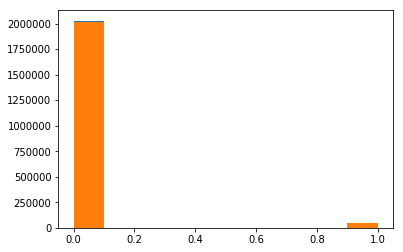

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
print("predicting_test_sample")
dff = pd.read_csv('input_data/test_sampling2.csv')
print(dff.head())
dff, yy = clear_data(dff,'train')
dff = dff.drop(columns=['Unnamed: 0'])
output = model.predict(dff,batch_size=batch_size,verbose=2)

del dff; gc.collect()

predicting_test_sample
   Unnamed: 0      ip  app  device  os  channel           click_time  \
0    74817458  170903   18       1  49      439  2017-11-08 01:45:53   
1     7284525   14751    2       1  13      205  2017-11-06 23:10:42   
2    10045104  107021   13       1  13      477  2017-11-07 00:12:47   
3   142591786   41805    3       1  19      173  2017-11-09 03:23:17   
4   108780762   82168   12       1  13      245  2017-11-08 12:14:03   

  attributed_time  is_attributed  
0             NaN              0  
1             NaN              0  
2             NaN              0  
3             NaN              0  
4             NaN              0  


3515

[ 0.0041095   0.00365445  0.0042511  ...,  0.00367037  0.00361505
  0.00366381]
(18490389,)


(array([ 18444773.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,     45616.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

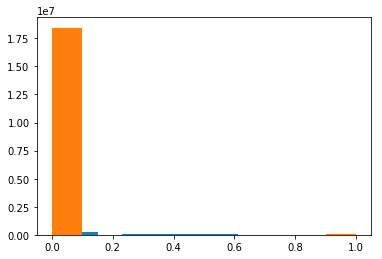

In [10]:
print(np.reshape(output,18490389))
print(yy.shape)
# dd = np.array([np.reshape(output,18490389),yy.values])
plt.hist(output)
plt.hist(yy)



(array([  1.79450250e+07,   2.53514000e+05,   2.47950000e+04,
          3.44290000e+04,   4.20800000e+04,   8.38380000e+04,
          3.21530000e+04,   5.28730000e+04,   8.84200000e+03,
          1.28400000e+04]),
 array([  5.13673455e-22,   7.65968323e-02,   1.53193665e-01,
          2.29790497e-01,   3.06387329e-01,   3.82984161e-01,
          4.59580994e-01,   5.36177826e-01,   6.12774658e-01,
          6.89371490e-01,   7.65968323e-01]),
 <a list of 10 Patch objects>)

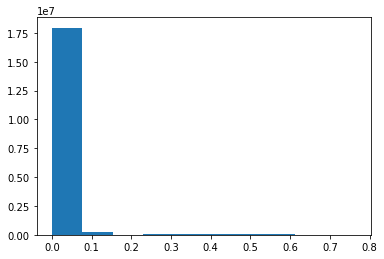

In [11]:
plt.hist(output)

In [ ]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('input_data/kaggle_test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


In [ ]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [ ]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample2.csv',index=False)




In [ ]:
plt.hist(np.round(df_sub['is_attributed']))